In [1]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from matplotlib import colormaps

## alexnet stuff

In [28]:
# load pretrainded AlexNet model
model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# remove the last layer to get the feature vector
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# transform the input image to the format expected by the model
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_embeddings(img_path):
    img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
    with torch.no_grad():
    # with torch.no_grad() is used to disable gradient calculation
        return model(img)

## get embeddings of stims used in expt

In [ ]:
# # get list of shapes used as targets
# trials_df = pd.read_csv('../input_data/trials_no_noise.csv')
# shape_files_used = trials_df['target_file'].tolist()
# alex_embeds = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]

# # convert to df
# alex_embeds_df = pd.DataFrame([(k, *v.squeeze().numpy()) for k, v in alex_embeds])
# alex_embeds_df.columns = ['shapes'] + [f'feature_{i}' for i in range(alex_embeds_df.shape[1] - 1)]

# # append associated stim & noise positions
# alex_embeds_df['stim_file_pos'] = trials_df['stim_file_pos']
# alex_embeds_df['noise_pos'] = trials_df['noise_pos']
# alex_embeds_df['div'] = trials_df['condition'].map({'baseline': 2, 'curv_comp': 1, 'flat_comp': 3})

# # additional cols based on combinations of conditions
# conditions = [
#     (alex_embeds_df['stim_file_pos'] < alex_embeds_df['div']) & (alex_embeds_df['div'] == 1),
#     (alex_embeds_df['stim_file_pos'] > alex_embeds_df['div']) & (alex_embeds_df['div'] == 1),
#     (alex_embeds_df['stim_file_pos'] < alex_embeds_df['div']) & (alex_embeds_df['div'] == 2),
#     (alex_embeds_df['stim_file_pos'] > alex_embeds_df['div']) & (alex_embeds_df['div'] == 2),
#     (alex_embeds_df['stim_file_pos'] < alex_embeds_df['div']) & (alex_embeds_df['div'] == 3),
#     (alex_embeds_df['stim_file_pos'] > alex_embeds_df['div']) & (alex_embeds_df['div'] == 3),
# ]
# values = [1, 2, 3, 4, 5, 6]
# alex_embeds_df['ShapeDiv_combo'] = np.select(conditions, values, default=np.nan)

# reorder_columns = ['shapes', 'div', 'stim_file_pos', 'noise_pos', 'ShapeDiv_combo'] + [col for col in alex_embeds_df.columns if col.startswith('feature_')]
# alex_embeds_df = alex_embeds_df[reorder_columns]

# # remove features with minimal variance across shapes
# feature_cols = [col for col in alex_embeds_df.columns if col.startswith('feature_')]
# variances = alex_embeds_df[feature_cols].var()
# threshold = 0.2
# low_variance_features = variances[variances < threshold].index
# alex_embeds_df = alex_embeds_df.drop(columns=low_variance_features)

# alex_embeds_df.to_csv('../input_data/alex_embeds.csv', index=False)

alexnet_df = pd.read_csv('../input_data/alex_embeds.csv')
print(len(alexnet_df))
alexnet_df.head(10)


240


,shapes,div,stim_file_pos,noise_pos,ShapeDiv_combo,feature_38,feature_45,feature_47,feature_52,feature_60,...,feature_3934,feature_3976,feature_3989,feature_4029,feature_4058,feature_4062,feature_4068,feature_4072,feature_4076,feature_4091
0,input_data/stims/Shape_0.10_2.00.png,2,0.1,2.0,3.0,0.0,3.773112,1.548227,9.893225,6.664485,...,0.842869,2.808657,0.339344,14.981912,7.056250,2.386146,0.0,2.748045,0.000000,0.254565
1,input_data/stims/Shape_0.10_2.00.png,2,0.1,2.0,3.0,0.0,3.773112,1.548227,9.893225,6.664485,...,0.842869,2.808657,0.339344,14.981912,7.056250,2.386146,0.0,2.748045,0.000000,0.254565
2,input_data/stims/Shape_0.30_2.00.png,2,0.3,2.0,3.0,0.0,4.203895,1.607291,10.380331,6.543702,...,1.540841,4.348639,0.536201,16.380620,6.874498,2.078945,0.0,3.509048,0.000000,0.420128
3,input_data/stims/Shape_0.30_2.00.png,2,0.3,2.0,3.0,0.0,4.203895,1.607291,10.380331,6.543702,...,1.540841,4.348639,0.536201,16.380620,6.874498,2.078945,0.0,3.509048,0.000000,0.420128
4,input_data/stims/Shape_0.50_2.00.png,2,0.5,2.0,3.0,0.0,5.207516,1.555116,11.054083,6.980928,...,1.904529,5.207638,0.535548,17.037040,6.800977,1.686080,0.0,3.610410,0.000000,1.003617
5,input_data/stims/Shape_0.50_2.00.png,2,0.5,2.0,3.0,0.0,5.207516,1.555116,11.054083,6.980928,...,1.904529,5.207638,0.535548,17.037040,6.800977,1.686080,0.0,3.610410,0.000000,1.003617
6,input_data/stims/Shape_0.70_2.00.png,2,0.7,2.0,3.0,0.0,4.965006,1.445977,11.062132,7.295739,...,1.980066,5.155291,0.570961,16.939823,6.422269,2.007997,0.0,3.765794,0.041847,1.243033
7,input_data/stims/Shape_0.70_2.00.png,2,0.7,2.0,3.0,0.0,4.965006,1.445977,11.062132,7.295739,...,1.980066,5.155291,0.570961,16.939823,6.422269,2.007997,0.0,3.765794,0.041847,1.243033
8,input_data/stims/Shape_0.90_2.00.png,2,0.9,2.0,3.0,0.0,4.882823,1.223518,11.144922,8.112886,...,2.103220,4.811977,0.917365,17.172209,6.635276,2.174239,0.0,3.620185,0.044253,0.763880
9,input_data/stims/Shape_0.90_2.00.png,2,0.9,2.0,3.0,0.0,4.882823,1.223518,11.144922,8.112886,...,2.103220,4.811977,0.917365,17.172209,6.635276,2.174239,0.0,3.620185,0.044253,0.763880


## plot stim embeddings from alexnet

alex_embeds_df.shape (n_trials, n_feats): (240, 300)


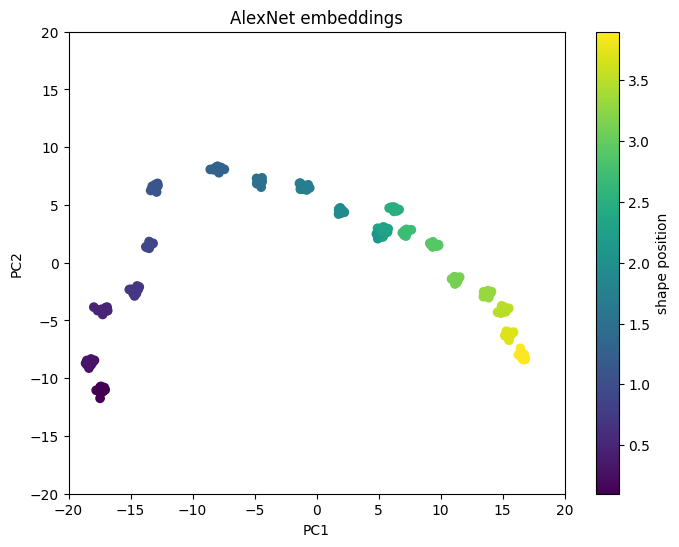

In [4]:
# sub-select cols
alex_embeds_df = alexnet_df[alexnet_df.columns[alexnet_df.columns.str.startswith('feature_')]]
print(f'alex_embeds_df.shape (n_trials, n_feats): {alex_embeds_df.shape}')

pca = PCA(n_components=2)
alex_feat_pc = pca.fit_transform(alex_embeds_df)
alex_feat_pc_df = pd.DataFrame(alex_feat_pc, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
jitter = .2
scatter = plt.scatter(alex_feat_pc_df['PC1'] + np.random.normal(0, jitter, size=len(alex_feat_pc_df)),
                      alex_feat_pc_df['PC2'] + np.random.normal(0, jitter, size=len(alex_feat_pc_df)),
                      c = alexnet_df['stim_file_pos'].values)
# scatter = plt.scatter(alex_feat_pc_df['PC1'], alex_feat_pc_df['PC2'], c=alexnet_df['stim_file_pos'].values)
plt.colorbar(scatter, label='shape position')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('AlexNet embeddings')
plt.show()


## building architecture of new NN

In [5]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, recon_dim, class_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, recon_dim)
        self.classification_output = nn.Linear(hidden_dim, class_dim)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # sigmoid output for classification (binary)
        # classification = torch.sigmoid(self.classification_output(x))
        classification = self.classification_output(x)
        
        return reconstruction, classification

## format features (X) & predictions (y_recon & y_class)

In [6]:
# 1.
feature_cols = [col for col in alexnet_df.columns if col.startswith('feature_')]
y_recon = alexnet_df[feature_cols].values # shape features

# 2. # store y_class col as binary, if stim_file_pos > div
alexnet_df['y_class'] = (alexnet_df['stim_file_pos'] >= alexnet_df['div']).astype(int)
y_class = alexnet_df['y_class'].values.reshape(-1, 1) # shape class (0 or 1)

# 3.
X = np.column_stack((y_recon, alexnet_df['div'].values))  # add 'div' column as context to predictor

print(f'div: {alexnet_df["div"].values}')
print(f'class: {alexnet_df["y_class"].values}')
print()
print(f'X.shape (n_trials, n_feats + div_cntxt): {X.shape}')
print(f'y_recon.shape (n_trials, n_feats): {y_recon.shape}')
print(f'y_class.shape (n_trials, 1): {y_class.shape}')
print()
n_feats = y_recon.shape[1]
print(f'n_feats: {n_feats}')


div: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
class: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

X.shape (n_

## cross-validation

≈0: 61 , ≈1: 83
True classes: [65 79]
min: -36.84135437011719, max: 27.436199188232422


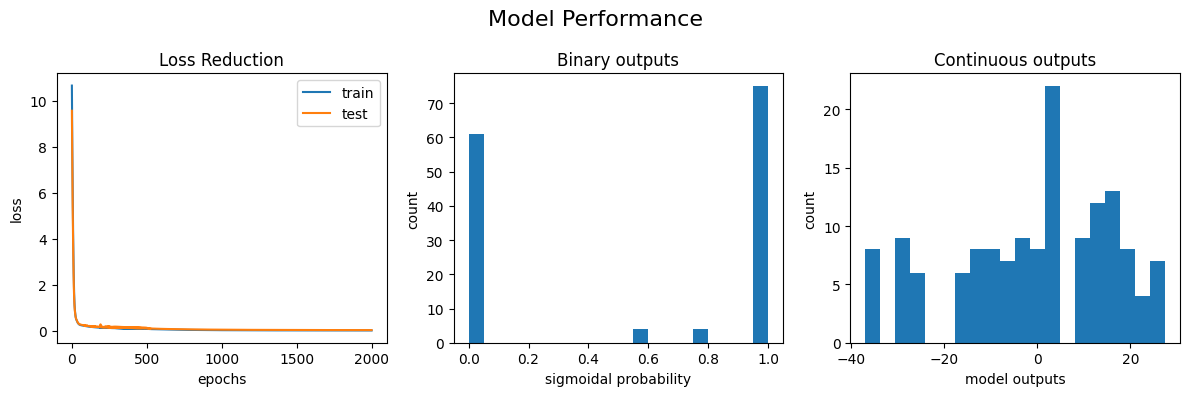

In [9]:
from sklearn.model_selection import train_test_split

# architecture params
# input_dim, hidden_dim, output_dim = n_feats+1, 128, n_feats+1
input_dim, hidden_dim, recon_dim, class_dim = X.shape[1], 128, y_recon.shape[1], 1
model = ShapeSideNN(input_dim, hidden_dim, recon_dim, class_dim)

# loss params
optimizer = optim.Adam(model.parameters(), lr=0.001)
recon_wt, class_wt, fp_wt = .5, .5, 1.0

# split into train and test once
X_train, X_test, y_recon_train, y_recon_test, y_class_train, y_class_test = train_test_split(
    X, y_recon, y_class, test_size=.6, random_state=42, shuffle=True
)

train_total_losses, train_recon_losses, train_class_losses = [], [], []
test_total_losses, test_recon_losses, test_class_losses = [], [], []
epochs = 2000

# training loop
for epoch in range(epochs):
    model.train()

    # forward pass to predict reconstruction & class
    pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

    # 1. reconstruction loss between pred & y
    train_recon_loss = nn.MSELoss()(pred_recon_train,
                                    torch.tensor(y_recon_train, dtype=torch.float32))

    # 2. classification loss 
    train_class_loss = nn.BCEWithLogitsLoss()(pred_class_train,
                                              torch.tensor(y_class_train, dtype=torch.float32))
    
    # no reduction means in unpacks/doesnt take mean across samples
    bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_train,
                                                 torch.tensor(y_class_train, dtype=torch.float32))
    # weight vector per sample, taking the form: y_true = 1 + y_true = 0
    weights = torch.tensor(y_class_train, dtype=torch.float32) + fp_wt * (1 - torch.tensor(y_class_train, dtype=torch.float32))
    # expected weighted error
    train_class_loss = (weights * bce).mean()

    # 3. weighted summed training loss
    train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

    # backward pass and optimization
    optimizer.zero_grad()
    train_total_loss.backward()
    # to try to take care of exploding gradients (manifested as sudden, high losses)?
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # testing model
    model.eval()
    with torch.no_grad():

        # predict test shape & class using trained model
        pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        

        # 1. recon losses between pred & y
        test_recon_loss = nn.MSELoss()(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))

        # 2. class loss
        test_class_loss = nn.BCEWithLogitsLoss()(pred_class_test,
                                                 torch.tensor(y_class_test, dtype=torch.float32))
        bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_test,
                                                     torch.tensor(y_class_test, dtype=torch.float32))
        weights = torch.tensor(y_class_test, dtype=torch.float32) + fp_wt * (1 - torch.tensor(y_class_test, dtype=torch.float32))
        test_class_loss = (weights * bce).mean()
        
        # 3. weighted summed testing loss
        test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

    # appending train & test losses
    train_recon_losses.append(train_recon_loss.item())
    train_class_losses.append(train_class_loss.item())
    train_total_losses.append(train_total_loss.item())

    test_recon_losses.append(test_recon_loss.item())
    test_class_losses.append(test_class_loss.item())
    test_total_losses.append(test_total_loss.item())


fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs, ax = axs.flatten(), 0
fig.suptitle('Model Performance', fontsize=16)

# loss curves
axs[ax].plot(train_total_losses, label='train')
axs[ax].plot(test_total_losses, label='test')
axs[ax].set_xlabel('epochs')
axs[ax].set_ylabel('loss')
# axs[0].set_ylim(0, 5)
axs[ax].set_title('Loss Reduction')
axs[ax].legend()
ax += 1

# sigmoidal probabilities
sigmoid_probs = torch.sigmoid(pred_class_test).detach().numpy()
# print(f'Binary classification accuracy: {np.mean((sigmoid_probs > 0.5) == y_class_test.numpy())}')
print('≈0:', np.sum(sigmoid_probs < .5), ', ≈1:', np.sum(sigmoid_probs > .5))
print('True classes:', np.bincount(y_class_test.squeeze().astype(int)))
axs[ax].hist(sigmoid_probs, bins=20)
axs[ax].set_xlabel('sigmoidal probability')
axs[ax].set_ylabel('count')
axs[ax].set_title('Binary outputs')
ax += 1

# true predictions
model_outputs = pred_class_test.numpy()
# print min and max
print(f'min: {np.min(model_outputs)}, max: {np.max(model_outputs)}')
axs[ax].hist(model_outputs, bins=20)
axs[ax].set_xlabel('model outputs')
axs[ax].set_ylabel('count')
axs[ax].set_title('Continuous outputs')

plt.tight_layout()
plt.show()



## reward-based supervised training

In [13]:
# from sklearn.model_selection import train_test_split

# # architecture params
# # input_dim, hidden_dim, output_dim = n_feats+1, 128, n_feats+1
# input_dim, hidden_dim, recon_dim, class_dim = X.shape[1], 128, y_recon.shape[1], 1
# model = ShapeSideNN(input_dim, hidden_dim, recon_dim, class_dim)

# # loss params
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = .5, .5

# # reward matrix: (true_label, predicted_label) → reward
# reward_matrix = {
#     (1, 1): 3,   # true positive
#     (0, 0): 1,   # true negative
#     (1, 0): -1,  # false negative
#     (0, 1): -3   # false positive
# }
# # negation to cast as loss
# cost_matrix = {k: -v for k, v in reward_matrix.items()}

# # split into train and test once
# X_train, X_test, y_recon_train, y_recon_test, y_class_train, y_class_test = train_test_split(
#     X, y_recon, y_class, test_size=.6, random_state=42, shuffle=True
# )

# train_total_losses, train_recon_losses, train_class_losses = [], [], []
# test_total_losses, test_recon_losses, test_class_losses = [], [], []
# epochs = 2000

# # training loop
# for epoch in range(epochs):
#     model.train()

#     # forward pass to predict reconstruction & class
#     pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

#     # 1. reconstruction loss between pred & y
#     train_recon_loss = nn.MSELoss()(pred_recon_train,
#                                     torch.tensor(y_recon_train, dtype=torch.float32))

#     # 2. classification loss 
#     # get binary predicted class from logits
#     sigmoids = (torch.sigmoid(pred_class_train) >= .5).float()

#     # map (true, pred) → cost
#     weights = torch.tensor([
#         cost_matrix[(t.item(), p.item())] for t, p in zip(y_class_train, sigmoids)
#     ], dtype=torch.float32).unsqueeze(1)

#     # compute loss per sample, then apply cost-based weights
#     bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_train,
#                                                  torch.tensor(y_class_train, dtype=torch.float32))
#     train_class_loss = (weights * bce).mean()

#     # 3. weighted summed training loss
#     train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#     # backward pass and optimization
#     optimizer.zero_grad()
#     train_total_loss.backward()
#     # to try to take care of exploding gradients (manifested as sudden, high losses)?
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()

#     # testing model
#     model.eval()
#     with torch.no_grad():

#         # predict test shape & class using trained model
#         pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        

#         # 1. recon losses between pred & y
#         test_recon_loss = nn.MSELoss()(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))

#         # 2. class loss
#         # get binary predicted class from logits
#         sigmoids = (torch.sigmoid(pred_class_test) >= .5).float()

#         # map (true, pred) → cost
#         weights = torch.tensor([
#             cost_matrix[(t.item(), p.item())] for t, p in zip(y_class_test, sigmoids)
#         ], dtype=torch.float32).unsqueeze(1)

#         # compute loss per sample, then apply cost-based weights
#         bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_test,
#                                                     torch.tensor(y_class_test, dtype=torch.float32))
#         test_class_loss = (weights * bce).mean()

#         # 3. weighted summed training loss
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # 3. weighted summed testing loss
#         test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

#     # appending train & test losses
#     train_recon_losses.append(train_recon_loss.item())
#     train_class_losses.append(train_class_loss.item())
#     train_total_losses.append(train_total_loss.item())

#     test_recon_losses.append(test_recon_loss.item())
#     test_class_losses.append(test_class_loss.item())
#     test_total_losses.append(test_total_loss.item())


# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs, ax = axs.flatten(), 0
# fig.suptitle('Model Performance', fontsize=16)

# # loss curves
# axs[ax].plot(train_total_losses, label='train')
# axs[ax].plot(test_total_losses, label='test')
# axs[ax].set_xlabel('epochs')
# axs[ax].set_ylabel('loss')
# # axs[0].set_ylim(0, 5)
# axs[ax].set_title('Loss Reduction')
# axs[ax].legend()
# ax += 1

# # sigmoidal probabilities
# sigmoids = torch.sigmoid(pred_class_test).detach().numpy()
# # print(f'Binary classification accuracy: {np.mean((sigmoids > 0.5) == y_class_test.numpy())}')
# print('≈0:', np.sum(sigmoids < .5), ', ≈1:', np.sum(sigmoids > .5))
# print('True classes:', np.bincount(y_class_test.squeeze().astype(int)))
# axs[ax].hist(sigmoids, bins=20)
# axs[ax].set_xlabel('sigmoidal probability')
# axs[ax].set_ylabel('count')
# axs[ax].set_title('Binary outputs')
# ax += 1

# # true predictions
# model_outputs = pred_class_test.numpy()
# # print min and max
# print(f'min: {np.min(model_outputs)}, max: {np.max(model_outputs)}')
# axs[ax].hist(model_outputs, bins=20)
# axs[ax].set_xlabel('model outputs')
# axs[ax].set_ylabel('count')
# axs[ax].set_title('Continuous outputs')

# plt.tight_layout()
# plt.show()



In [18]:
# Get hidden layer activations
with torch.no_grad():
    nn_hidden = model.hidden(torch.tensor(X, dtype=torch.float32)).numpy()

# create column names and convert to df
hidden_cols = [f'hidden_{i}' for i in range(nn_hidden.shape[1])]
hidden_df = pd.DataFrame(nn_hidden, columns=hidden_cols)
print(f'nn_hidden_df.shape (n_trials, n_hidden_units): {hidden_df.shape}')

nn_df = pd.concat([alexnet_df.drop(columns=[col for col in alexnet_df.columns if col.startswith('features_')]),
                   hidden_df], axis=1)
nn_df.head()

nn_hidden_df.shape (n_trials, n_hidden_units): (240, 128)


,shapes,div,stim_file_pos,noise_pos,ShapeDiv_combo,feature_38,feature_45,feature_47,feature_52,feature_60,...,hidden_118,hidden_119,hidden_120,hidden_121,hidden_122,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127
0,input_data/stims/Shape_0.10_2.00.png,2,0.1,2.0,3.0,0.0,3.773112,1.548227,9.893225,6.664485,...,-1.130600,10.951844,-8.716146,-5.181156,-5.869818,-7.058080,-4.073160,1.490471,-2.813346,-6.946728
1,input_data/stims/Shape_0.10_2.00.png,2,0.1,2.0,3.0,0.0,3.773112,1.548227,9.893225,6.664485,...,-1.130600,10.951844,-8.716146,-5.181156,-5.869818,-7.058080,-4.073160,1.490471,-2.813346,-6.946728
2,input_data/stims/Shape_0.30_2.00.png,2,0.3,2.0,3.0,0.0,4.203895,1.607291,10.380331,6.543702,...,-0.980732,11.131622,-9.745948,-5.260638,-6.115030,-7.461129,-4.052501,0.572418,-3.403405,-7.064895
3,input_data/stims/Shape_0.30_2.00.png,2,0.3,2.0,3.0,0.0,4.203895,1.607291,10.380331,6.543702,...,-0.980732,11.131622,-9.745948,-5.260638,-6.115030,-7.461129,-4.052501,0.572418,-3.403405,-7.064895
4,input_data/stims/Shape_0.50_2.00.png,2,0.5,2.0,3.0,0.0,5.207516,1.555116,11.054083,6.980928,...,-0.567255,11.562826,-9.680370,-5.667505,-6.419117,-7.485981,-4.303057,0.600285,-4.108788,-7.255159


## visualize hidden layer

nn_hidden_df.shape (n_trials, n_hidden_units): (240, 128)


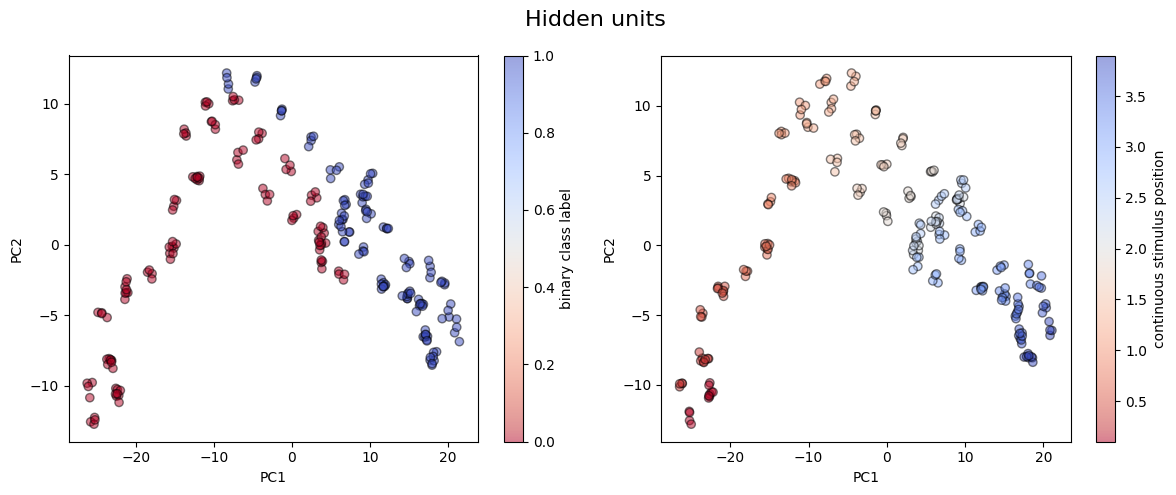

In [ ]:
pca = PCA(n_components=2)
hidden_pc = pca.fit_transform(hidden_df)
hidden_pc_df = pd.DataFrame(hidden_pc, columns=['PC1', 'PC2'])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs, ax = axs.flatten(), 0
fig.suptitle('Hidden units', fontsize=16)

scatter1 = axs[0].scatter(hidden_pc_df['PC1'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          hidden_pc_df['PC2'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          c = alexnet_df['y_class'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter1, ax=axs[0], label='binary class label')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
ax += 1

scatter2 = axs[1].scatter(hidden_pc_df['PC1'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          hidden_pc_df['PC2'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          c = alexnet_df['stim_file_pos'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter2, ax=axs[1], label='continuous stimulus position')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')

plt.tight_layout()
plt.show()


## comparing class clusters

mid_space_df.shape (n_select_trials, n_hidden_units): (120, 128)
class0_df.shape (n_select_trials, n_hidden_units): (120, 128)


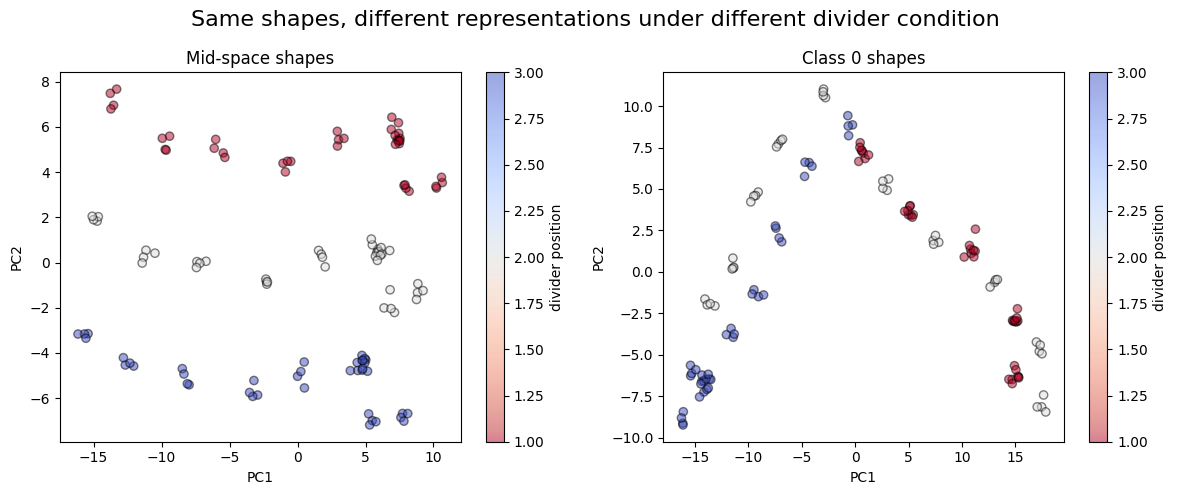

In [ ]:
# 1.
ids = alexnet_df[(alexnet_df['stim_file_pos'] >= 1) & (alexnet_df['stim_file_pos'] <= 3)].index
mid_space_df = hidden_df.iloc[ids]
print(f'mid_space_df.shape (n_select_trials, n_hidden_units): {mid_space_df.shape}')

pca = PCA(n_components=2)
mid_space_pc_df = pd.DataFrame(pca.fit_transform(mid_space_df), columns=['PC1', 'PC2'])

# 2.
ids = alexnet_df[alexnet_df['y_class'] == 0].index
class0_df = hidden_df.iloc[ids]
print(f'class0_df.shape (n_select_trials, n_hidden_units): {class0_df.shape}')

pca = PCA(n_components=2)
class0_pc_df = pd.DataFrame(pca.fit_transform(class0_df), columns=['PC1', 'PC2'])

# plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs, ax = axs.flatten(), 0
fig.suptitle('Same shapes, different representations under different divider condition', fontsize=16)
jitter = .3

scatter1 = axs[ax].scatter(mid_space_pc_df['PC1'] + np.random.normal(0, jitter, size=len(mid_space_pc_df)),
                           mid_space_pc_df['PC2'] + np.random.normal(0, jitter, size=len(mid_space_pc_df)),
                           c = alexnet_df['div'].iloc[ids].values, cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter1, ax=axs[ax], label='divider position')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
axs[ax].set_title('Mid-space shapes')
ax += 1

scatter1 = axs[ax].scatter( class0_pc_df['PC1'] + np.random.normal(0, jitter, size=len(class0_pc_df)),
                            class0_pc_df['PC2'] + np.random.normal(0, jitter, size=len(class0_pc_df)),
                            c = alexnet_df['div'].iloc[ids].values, cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter1, ax=axs[ax], label='divider position')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
axs[ax].set_title('Class 0 shapes')

plt.tight_layout()
plt.show()

## distance from neutral

In [19]:
nn_df.head()

,shapes,div,stim_file_pos,noise_pos,ShapeDiv_combo,feature_38,feature_45,feature_47,feature_52,feature_60,...,hidden_118,hidden_119,hidden_120,hidden_121,hidden_122,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127
0,input_data/stims/Shape_0.10_2.00.png,2,0.1,2.0,3.0,0.0,3.773112,1.548227,9.893225,6.664485,...,-1.130600,10.951844,-8.716146,-5.181156,-5.869818,-7.058080,-4.073160,1.490471,-2.813346,-6.946728
1,input_data/stims/Shape_0.10_2.00.png,2,0.1,2.0,3.0,0.0,3.773112,1.548227,9.893225,6.664485,...,-1.130600,10.951844,-8.716146,-5.181156,-5.869818,-7.058080,-4.073160,1.490471,-2.813346,-6.946728
2,input_data/stims/Shape_0.30_2.00.png,2,0.3,2.0,3.0,0.0,4.203895,1.607291,10.380331,6.543702,...,-0.980732,11.131622,-9.745948,-5.260638,-6.115030,-7.461129,-4.052501,0.572418,-3.403405,-7.064895
3,input_data/stims/Shape_0.30_2.00.png,2,0.3,2.0,3.0,0.0,4.203895,1.607291,10.380331,6.543702,...,-0.980732,11.131622,-9.745948,-5.260638,-6.115030,-7.461129,-4.052501,0.572418,-3.403405,-7.064895
4,input_data/stims/Shape_0.50_2.00.png,2,0.5,2.0,3.0,0.0,5.207516,1.555116,11.054083,6.980928,...,-0.567255,11.562826,-9.680370,-5.667505,-6.419117,-7.485981,-4.303057,0.600285,-4.108788,-7.255159


2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0


KeyError: '1D_dist_from_div'

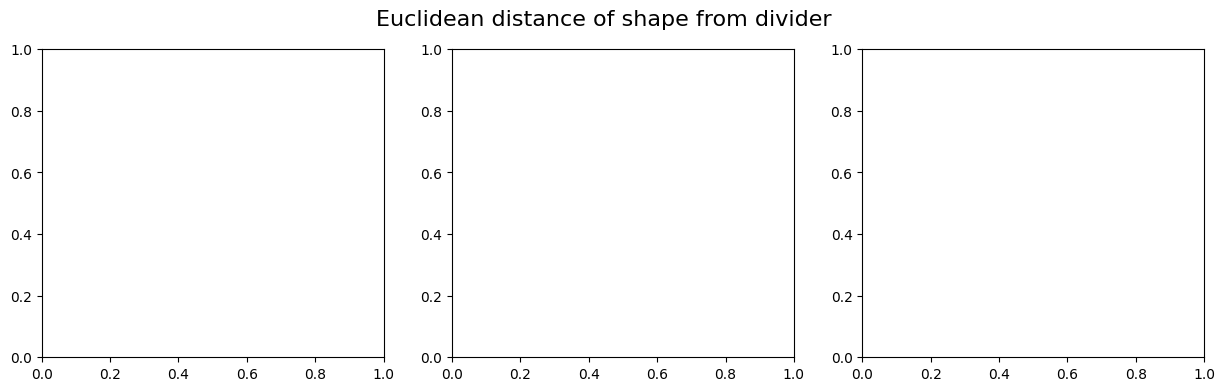

In [ ]:
# 1. get 1D distance of each shape from divider
nn_df['1D_dist_frm_div'] = np.abs(nn_df['stim_file_pos'] - nn_df['div'])

# 2. get euclidean distance of each shape from divider

# store 3 div_shape embeds
div_shape_names = ['input_data/stims/Shape_2.10_2.00.png', 'input_data/stims/Shape_1.10_2.00.png', 'input_data/stims/Shape_3.10_2.00.png']

div_shape_embeds = {1: [],
                    2: [],
                    3: []}

# save images through matlab
# get embeddings and store as df?
# drop dfs that do not exist in alexnet_df


for shape_id in range(len(nn_df)):

    div = nn_df['div'].iloc[shape_id]
    div_shape_embed = div_shape_embeds[div]

    # store euclidean distance to div_shape
    nn_df['euc_dist_frm_div'].iloc[shape_id] = np.linalg.norm(hidden_df.iloc[shape_id].values - div_shape_embed)

# reorder col names

########################################################



# fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# axs, ax = ax.flatten(), 0
# fig.suptitle('Euclidean distance of shape from divider', fontsize=16)

# for div, div_df in nn_df.groupby('div'):

#     # get divider shape info
#     div_shape_file = div_shapes[div] # name
#     div_shape_id = nn_df[nn_df['shapes'] == div_shape_file].index[0] # row_id from full df

#     # only retain hidden unit cols
#     div_hidden_df = div_df[div_df.columns[div_df.columns.str.startswith('hidden_')]]
#     div_shape = div_hidden_df.iloc[div_shape_id] # get shape row from div_hidden_df

#     dists = {} # key = 1D dist, value = euclidean dist

#     for i, shape in div_hidden_df.iterrows():
        
#         euclidean_dists = np.linalg.norm(shape.values - div_shape.values)

#         # store in dict
#         dists[alexnet_df['1D_dist_from_div'].iloc[i]] = euclidean_dists
    
#     ax += 1


In [ ]:
# could replace MSE with ssim
# remove asymmetry and add reward
# find distance metrics

## k-fold CV

In [ ]:
# from sklearn.model_selection import KFold

# # architecture params
# input_dim, hidden_dim, output_dim = n_feats, 128, n_feats
# model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# # loss params
# recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = 0, 5

# # convert to numpy arrays for compatibility with KFold
# X, y_recon, y_class = np.array(X), np.array(y_recon), np.array(y_class)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# fold_total_losses, fold_recon_losses, fold_class_losses = [], [], []
# epochs = 2500

# # CV loop
# for fold, (train_id, test_id) in enumerate(kf.split(X)):

#     print(f'fold {fold+1}', end=', ')

#     # split into train and test
#     X_train, X_test = X[train_id], X[test_id]
#     y_recon_train, y_recon_test = y_recon[train_id], y_recon[test_id]
#     y_class_train, y_class_test = y_class[train_id], y_class[test_id]

#     # initialize model, loss, and optimizer
#     model = ShapeSideNN(input_dim, hidden_dim, output_dim)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     epoch_total_losses, epoch_recon_losses, epoch_class_losses = [], [], []
#     beta = 3.0
#     # training loop
#     for epoch in range(epochs):
#         model.train()

#         # forward pass to predict reconstruction & class
#         pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))
#         pred_class_train = torch.sigmoid(pred_class_train)

#         # calculate training losses between pred & y
#         train_recon_loss = recon_loss_fn(pred_recon_train, torch.tensor(y_recon_train, dtype=torch.float32))
#         train_class_loss = class_loss_fn(pred_class_train, torch.tensor(y_class_train, dtype=torch.float32))
#         # weighted sum
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # backward pass and optimization; training
#         optimizer.zero_grad()
#         train_total_loss.backward()
#         optimizer.step()

#         # testing model
#         model.eval()
#         test_total_losses, test_recon_losses, test_class_losses = [], [], []
#         with torch.no_grad():

#             # predict left-out (test) shape & class based using trained model on left-out embeddings
#             pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))
#             pred_class_test = torch.sigmoid(pred_class_test)

#             # calculate testing losses between pred & y
#             test_recon_loss = recon_loss_fn(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))
#             test_class_loss = class_loss_fn(pred_class_test, torch.tensor(y_class_test, dtype=torch.float32))
#             test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

#         # appending epoch losses
#         epoch_recon_losses.append(test_recon_loss.item())
#         epoch_class_losses.append(test_class_loss.item())
#         epoch_total_losses.append(test_total_loss.item())

#     # appending fold losses
#     fold_recon_losses.append(epoch_recon_losses)
#     fold_class_losses.append(epoch_class_losses)
#     fold_total_losses.append(epoch_total_losses)

# # plot losses
# plt.figure(figsize=(8, 5))
# for i in range(5):
#     plt.plot(fold_total_losses[i], label=f'fold {i+1} class loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('5-fold CV')
# plt.legend()
# plt.show()
